<a href="https://colab.research.google.com/github/Jbuck1016/Odds-Tables-Old/blob/main/newest_model_building_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

# Get the filename of the uploaded file
filename = next(iter(uploaded))

# Read the uploaded file into a dataframe
merged_df = pd.read_csv(filename)

merged_df['home_goals_allowed'] = merged_df['away_goals']
merged_df['away_goals_allowed'] = merged_df['home_goals']
merged_df.head(10)

# Define a function to determine the match result
def determine_result(row):
    if row['home_goals'] > row['away_goals']:
        return row['home_team']
    elif row['home_goals'] < row['away_goals']:
        return row['away_team']
    else:
        return 'Draw'

# Apply this function across the DataFrame to create the 'result' column
merged_df['result'] = merged_df.apply(determine_result, axis=1)

# Display the updated DataFrame to verify the new 'result' column
print(merged_df[['home_team', 'away_team', 'home_goals', 'away_goals', 'result']].head())

import pandas as pd
# Regular expression to extract the date: looking for patterns like '2023-08-11'
date_pattern = r'(\d{4}-\d{2}-\d{2})'

# Extract the date from the 'game' column and create a new 'date' column
merged_df['date'] = merged_df['game'].str.extract(date_pattern)

Saving most_updated_full_epl_data_20_24.csv to most_updated_full_epl_data_20_24.csv
         home_team          away_team  home_goals  away_goals           result
0          Burnley    Manchester City         0.0         3.0  Manchester City
1          Burnley    Manchester City         0.0         3.0  Manchester City
2  AFC Bournemouth    West Ham United         1.0         1.0             Draw
3  AFC Bournemouth    West Ham United         1.0         1.0             Draw
4          Arsenal  Nottingham Forest         2.0         1.0          Arsenal


In [ ]:
import pandas as pd

# Assuming 'merged_df' is your existing DataFrame

# Function to determine the opponent based on current team and game setup
def identify_opponent(row):
    if row['team'] == row['home_team']:
        return row['away_team']
    else:
        return row['home_team']

# Apply the function to create a new 'opponent' column
merged_df['opponent'] = merged_df.apply(identify_opponent, axis=1)

# Print the DataFrame to verify the new column
print(merged_df[['game_id_team', 'team', 'home_team', 'away_team', 'opponent']].head())


   game_id_team             team        home_team          away_team  \
0       4193450          Burnley          Burnley    Manchester City   
1       4193450  Manchester City          Burnley    Manchester City   
2       4193452  AFC Bournemouth  AFC Bournemouth    West Ham United   
3       4193452  West Ham United  AFC Bournemouth    West Ham United   
4       4193451          Arsenal          Arsenal  Nottingham Forest   

            opponent  
0    Manchester City  
1            Burnley  
2    West Ham United  
3    AFC Bournemouth  
4  Nottingham Forest  


In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame with historical match data
# Ensure the DataFrame is sorted by date in ascending order (oldest first)
merged_df.sort_values(by='date', ascending=True, inplace=True)

# Define a function to calculate form metrics for home and away teams
def calculate_form_metrics(df):
    # Initialize columns for form metrics
    df['home_form'] = None
    df['away_form'] = None

    # Unique teams
    teams = pd.concat([df['home_team'], df['away_team']]).unique()

    # Calculate form for each team
    for team in teams:
        # Home games for the team
        home_games = df[df['home_team'] == team]
        for i in range(len(home_games)):
            past_5_home = home_games.iloc[max(0, i-5):i]
            if not past_5_home.empty:
                goal_diff = (past_5_home['home_goals'] - past_5_home['home_goals_allowed']).sum()
                points = past_5_home['home_points'].sum()
                df.loc[past_5_home.index[-1], 'home_form'] = (goal_diff + (points / 15)) / 2

        # Away games for the team
        away_games = df[df['away_team'] == team]
        for i in range(len(away_games)):
            past_5_away = away_games.iloc[max(0, i-5):i]
            if not past_5_away.empty:
                goal_diff = (past_5_away['away_goals'] - past_5_away['away_goals_allowed']).sum()
                points = past_5_away['away_points'].sum()
                df.loc[past_5_away.index[-1], 'away_form'] = (goal_diff + (points / 15)) / 2

# Apply the function to calculate form metrics
calculate_form_metrics(merged_df)

# Check the results
print(merged_df[['game_id_team', 'team', 'home_team', 'away_team', 'date', 'home_form', 'away_form']].head())

      game_id_team              team        home_team         away_team  \
2164       3411351    Crystal Palace   Crystal Palace       Southampton   
2931       3411356   West Ham United  West Ham United  Newcastle United   
2930       3411356  Newcastle United  West Ham United  Newcastle United   
2929       3411353         Liverpool        Liverpool      Leeds United   
2928       3411353      Leeds United        Liverpool      Leeds United   

            date home_form away_form  
2164  2020-09-12       0.6      -0.5  
2931  2020-09-12      -1.0       1.1  
2930  2020-09-12      -2.0       2.2  
2929  2020-09-12       0.6      -0.5  
2928  2020-09-12       1.2      -1.0  


In [ ]:
import pandas as pd

# Assuming merged_df is your existing DataFrame

# Step 1: Compute the first non-NaN 'home_form' and 'away_form' for each 'game_id_team'
first_valid_forms = merged_df.groupby('game_id_team').agg({
    'home_form': lambda x: x.dropna().iloc[0] if not x.dropna().empty else pd.NA,
    'away_form': lambda x: x.dropna().iloc[0] if not x.dropna().empty else pd.NA
}).reset_index()

# Step 2: Merge these values back to the original DataFrame to update all rows accordingly
merged_df = pd.merge(merged_df, first_valid_forms, on='game_id_team', suffixes=('', '_updated'))

# Replace old form values with the updated ones from the first non-NaN value found in each group
merged_df['home_form'] = merged_df['home_form_updated']
merged_df['away_form'] = merged_df['away_form_updated']

# Optionally, you can drop the temporary '_updated' columns after the update
merged_df.drop(columns=['home_form_updated', 'away_form_updated'], inplace=True)

# Verify the result by printing out some of the updated DataFrame
print(merged_df[['game_id_team', 'home_team', 'away_team', 'home_form', 'away_form']].head())


   game_id_team        home_team         away_team  home_form  away_form
0       3411351   Crystal Palace       Southampton        0.6       -0.5
1       3411351   Crystal Palace       Southampton        0.6       -0.5
2       3411351   Crystal Palace       Southampton        0.6       -0.5
3       3411351   Crystal Palace       Southampton        0.6       -0.5
4       3411356  West Ham United  Newcastle United       -1.0        1.1


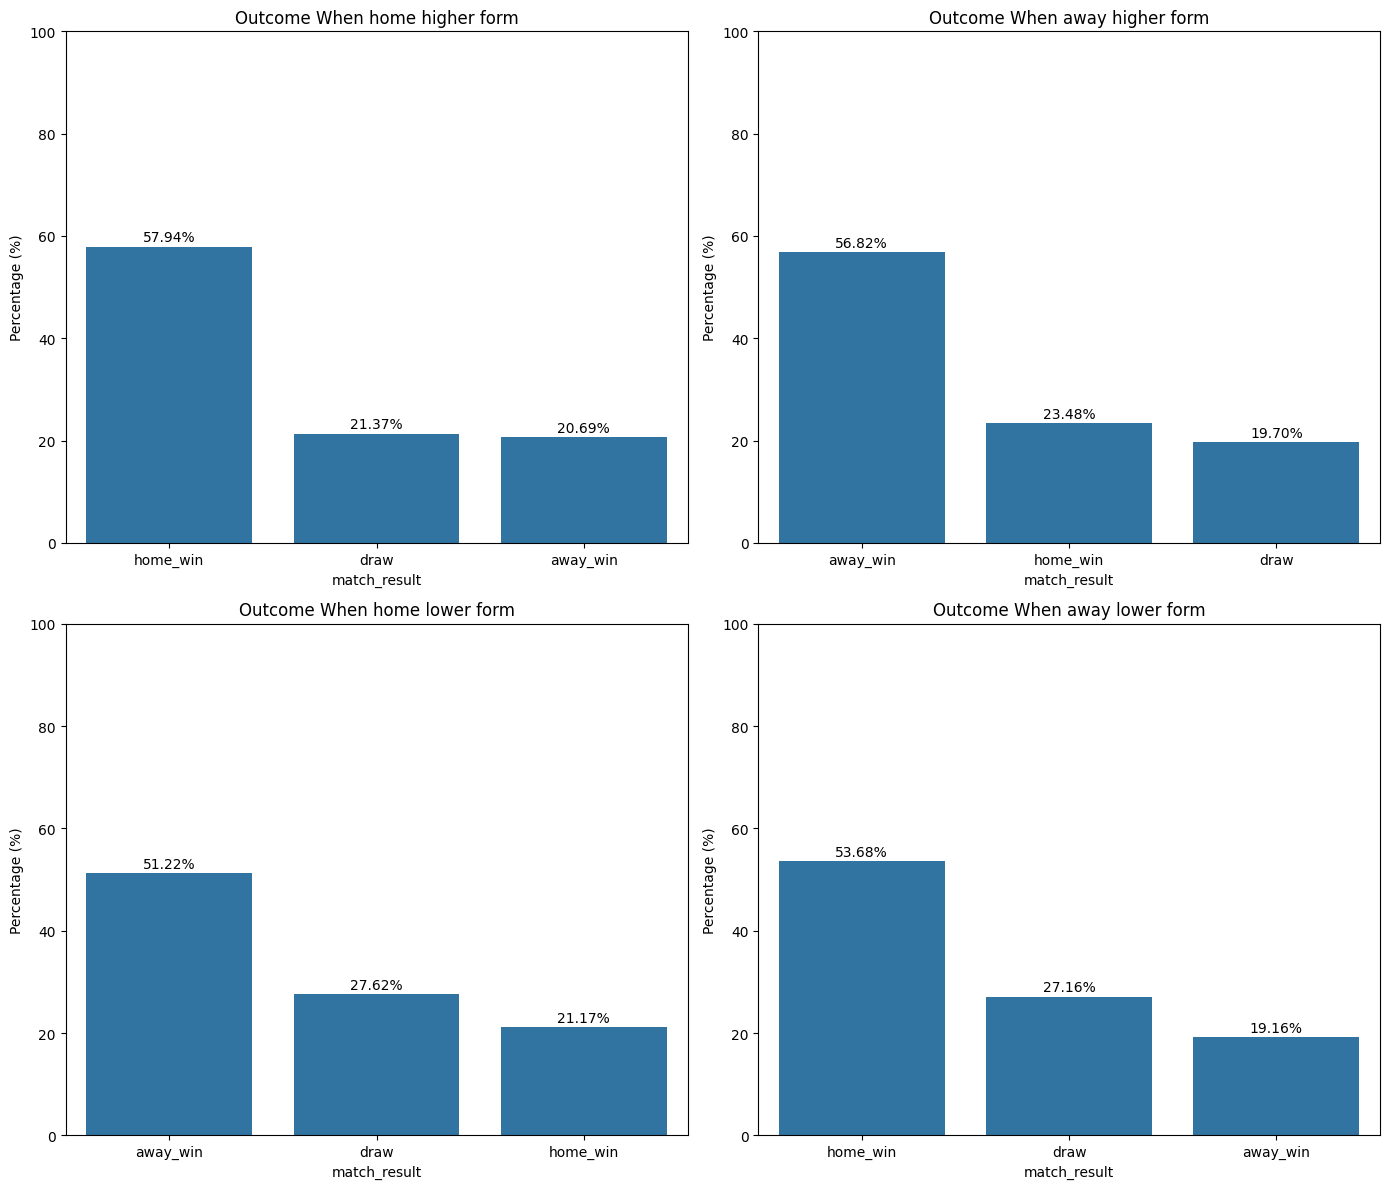

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df is defined and includes the necessary columns

# Function to determine higher form, handling NaN values by treating them as 'equal'
def determine_higher_form(row):
    if pd.isna(row['home_form']) or pd.isna(row['away_form']):
        return 'equal'  # Default to equal if any form value is NaN
    elif row['home_form'] > row['away_form']:
        return 'home'
    elif row['home_form'] < row['away_form']:
        return 'away'
    else:
        return 'equal'

# Applying the function
merged_df['higher_form'] = merged_df.apply(determine_higher_form, axis=1)

# Determine match result
def match_result(row):
    if row['home_goals'] > row['away_goals']:
        return 'home_win'
    elif row['home_goals'] < row['away_goals']:
        return 'away_win'
    else:
        return 'draw'

merged_df['match_result'] = merged_df.apply(match_result, axis=1)

# Prepare to plot the outcomes based on the higher form
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
scenarios = ['home_higher_form', 'away_higher_form', 'home_lower_form', 'away_lower_form']
for i, scenario in enumerate(scenarios):
    # Filter data for the scenario
    if scenario.endswith('higher_form'):
        condition = (merged_df['higher_form'] == scenario.split('_')[0])
    else:
        condition = (merged_df['higher_form'] != scenario.split('_')[0])

    subset = merged_df[condition]
    result_counts = subset['match_result'].value_counts(normalize=True) * 100
    sns.barplot(x=result_counts.index, y=result_counts.values, ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(f'Outcome When {scenario.replace("_", " ")}')
    axs[i // 2, i % 2].set_ylabel('Percentage (%)')
    axs[i // 2, i % 2].set_ylim(0, 100)

    # Annotate percentages on the bars
    for index, value in enumerate(result_counts):
        axs[i // 2, i % 2].text(index, value + 1, f'{value:.2f}%', ha='center')

plt.tight_layout()
plt.show()


                           Home Goals Correlation  Away Goals Correlation
xG on target (xGOT)                      0.326328                0.293475
home_deep_completions                    0.313078               -0.108253
Shots on target                          0.237149                0.193858
Big chances                              0.214691                0.195403
Expected goals (xG)                      0.210650                0.191546
xG non-penalty                           0.182281                0.162229
xG open play                             0.176721                0.162996
Touches in opposition box                0.102189                0.033133
Total shots                              0.085277                0.074222
xG set play                              0.067565                0.046455
Accurate crosses (%)                     0.036838                0.036185
Big chances missed                       0.014934               -0.008803
Successful dribbles                   

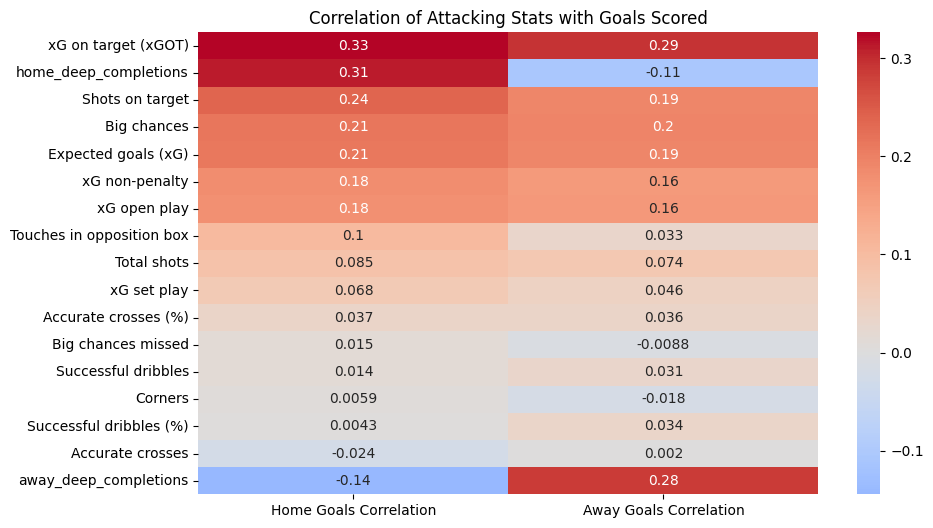

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with historical match data

# List of attacking-related stats
attacking_stats = [
    'Expected goals (xG)', 'xG open play', 'xG set play',
    'Total shots', 'Shots on target', 'Big chances', 'Accurate crosses (%)', 'Accurate crosses',
    'xG non-penalty', 'home_deep_completions', 'away_deep_completions',
    'Corners', 'Big chances missed', 'Touches in opposition box', 'Successful dribbles (%)', 'Successful dribbles', 'xG on target (xGOT)'
]

# Calculate the correlation of each attacking stat with 'home_goals' and 'away_goals'
correlations = {}
for stat in attacking_stats:
    correlation_with_home_goals = merged_df[stat].corr(merged_df['home_goals'])
    correlation_with_away_goals = merged_df[stat].corr(merged_df['away_goals'])
    correlations[stat] = {
        'Home Goals Correlation': correlation_with_home_goals,
        'Away Goals Correlation': correlation_with_away_goals
    }

# Convert the correlations dictionary to a DataFrame for easier analysis
correlation_df = pd.DataFrame(correlations).T

# Sort the DataFrame based on 'Home Goals Correlation' in descending order
correlation_df = correlation_df.sort_values(by='Home Goals Correlation', ascending=False)

# Print the sorted correlation DataFrame
print(correlation_df)

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Attacking Stats with Goals Scored')
plt.show()

                           Home Goals Correlation  Away Goals Correlation
away_deep_completions                   -0.144309                0.284931
Big chances                              0.214691                0.195403
Shots on target                          0.237149                0.193858
Expected goals (xG)                      0.210650                0.191546
xG open play                             0.176721                0.162996
xG non-penalty                           0.182281                0.162229
Total shots                              0.085277                0.074222
xG set play                              0.067565                0.046455
Accurate crosses (%)                     0.036838                0.036185
Touches in opposition box                0.102189                0.033133
Big chances missed                       0.014934               -0.008803
Corners                                  0.005860               -0.018244
home_deep_completions                 

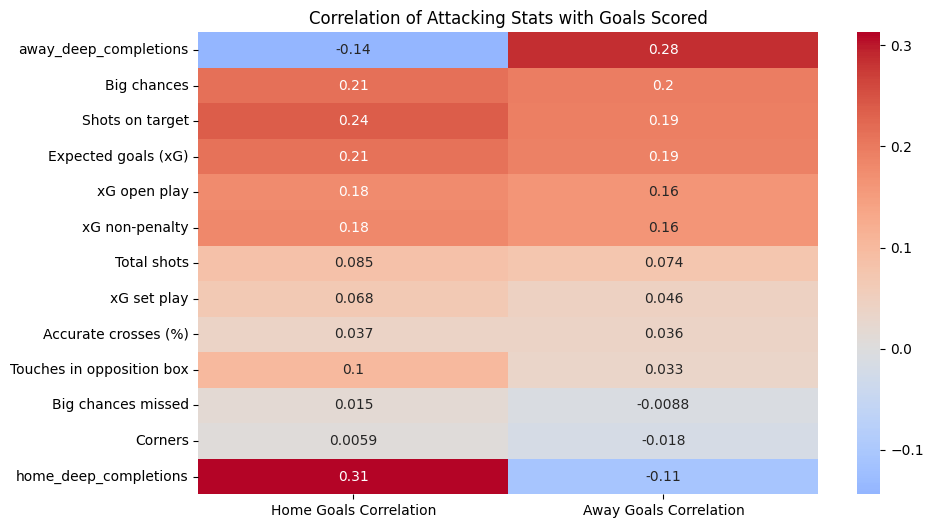

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with historical match data

# List of attacking-related stats
attacking_stats = [
    'Expected goals (xG)', 'xG open play', 'xG set play',
    'Total shots', 'Shots on target', 'Big chances', 'Accurate crosses (%)',
    'xG non-penalty', 'home_deep_completions', 'away_deep_completions',
    'Corners', 'Big chances missed', 'Touches in opposition box'
]

# Calculate the correlation of each attacking stat with 'home_goals' and 'away_goals'
correlations = {}
for stat in attacking_stats:
    correlation_with_home_goals = merged_df[stat].corr(merged_df['home_goals'])
    correlation_with_away_goals = merged_df[stat].corr(merged_df['away_goals'])
    correlations[stat] = {
        'Home Goals Correlation': correlation_with_home_goals,
        'Away Goals Correlation': correlation_with_away_goals
    }

# Convert the correlations dictionary to a DataFrame for easier analysis
correlation_df = pd.DataFrame(correlations).T

# Sort the DataFrame based on 'Home Goals Correlation' in descending order
correlation_df = correlation_df.sort_values(by='Away Goals Correlation', ascending=False)

# Print the sorted correlation DataFrame
print(correlation_df)

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Attacking Stats with Goals Scored')
plt.show()

In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame with historical match data

# List of attacking-related stats
attacking_stats = [
    'xG on target (xGOT)', 'home_deep_completions', 'Shots on target', 'Big chances',
    'Expected goals (xG)', 'xG non-penalty', 'xG open play', 'Total shots',
    'xG set play', 'Touches in opposition box', 'Accurate crosses (%)',
    'Big chances missed', 'Successful dribbles', 'Corners',
    'Successful dribbles (%)', 'Accurate crosses', 'away_deep_completions'
]

# Calculate the correlation of each attacking stat with 'home_goals' and 'away_goals'
correlations = {}
for stat in attacking_stats:
    correlation_with_home_goals = merged_df[stat].corr(merged_df['home_goals'])
    correlation_with_away_goals = merged_df[stat].corr(merged_df['away_goals'])
    correlations[stat] = {
        'Home Goals Correlation': correlation_with_home_goals,
        'Away Goals Correlation': correlation_with_away_goals
    }

# Convert the correlations dictionary to a DataFrame for easier analysis
correlation_df = pd.DataFrame(correlations).T

# Normalize the absolute correlation coefficients to use as weights
correlation_df['Home Weight'] = correlation_df['Home Goals Correlation'].abs() / correlation_df['Home Goals Correlation'].abs().sum()
correlation_df['Away Weight'] = correlation_df['Away Goals Correlation'].abs() / correlation_df['Away Goals Correlation'].abs().sum()

# Exclude 'away_deep_completions' for home metric calculation
home_weights = correlation_df.drop(index='away_deep_completions')['Home Weight']

# Exclude 'home_deep_completions' for away metric calculation
away_weights = correlation_df.drop(index='home_deep_completions')['Away Weight']

# Display the weights
print("Home Attacking Weights:\n", home_weights)
print("\nAway Attacking Weights:\n", away_weights)

Home Attacking Weights:
 xG on target (xGOT)          0.151076
home_deep_completions        0.144942
Shots on target              0.109790
Big chances                  0.099393
Expected goals (xG)          0.097522
xG non-penalty               0.084389
xG open play                 0.081814
Total shots                  0.039480
xG set play                  0.031280
Touches in opposition box    0.047310
Accurate crosses (%)         0.017054
Big chances missed           0.006914
Successful dribbles          0.006414
Corners                      0.002713
Successful dribbles (%)      0.001978
Accurate crosses             0.011121
Name: Home Weight, dtype: float64

Away Attacking Weights:
 xG on target (xGOT)          0.156383
Shots on target              0.103300
Big chances                  0.104124
Expected goals (xG)          0.102068
xG non-penalty               0.086446
xG open play                 0.086855
Total shots                  0.039550
xG set play                  0.024755
Tou

In [ ]:
import pandas as pd
from scipy.stats import zscore

# Assuming merged_df is your DataFrame with historical match data

# Create a copy of the DataFrame to work with Z-scores
df_with_zscores = merged_df.copy()

# Calculate Z-scores for the attacking stats in the copy
for stat in attacking_stats:
    df_with_zscores[f'{stat}_z'] = zscore(df_with_zscores[stat].fillna(0))

# Define a function to calculate the attacking metric using Z-scores and weights
def calculate_attacking_metric(row, home_weights, away_weights):
    metric = 0
    weights = home_weights if row['team'] == row['home_team'] else away_weights

    for stat in weights.index:  # Use the index of the weights Series to iterate
        z_stat = f'{stat}_z'
        if z_stat in row:
            metric += row[z_stat] * weights[stat]
    return metric

# Calculate the attacking metric for each game in the copy using Z-scores
df_with_zscores['attacking_metric_z'] = df_with_zscores.apply(
    calculate_attacking_metric, axis=1, args=(home_weights, away_weights)
)

# Calculate the rolling average of the last 5 attacking metrics for each team and season in the copy
df_with_zscores['avg_last_5_attacking_metric_z'] = df_with_zscores.groupby(['season', 'team'])['attacking_metric_z'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean().shift()
)

# Calculate the season average attacking metric up to the current game for each team and season in the copy
df_with_zscores['season_avg_attacking_metric_z'] = df_with_zscores.groupby(['season', 'team'])['attacking_metric_z'].transform(
    lambda x: x.expanding().mean().shift()
)

# Insert the calculated metrics back into the original DataFrame
merged_df['attacking_metric_z'] = df_with_zscores['attacking_metric_z']
merged_df['avg_last_5_attacking_metric_z'] = df_with_zscores['avg_last_5_attacking_metric_z']
merged_df['season_avg_attacking_metric_z'] = df_with_zscores['season_avg_attacking_metric_z']

# Now merged_df has additional columns with the calculated scores and averages
print(merged_df[['game_id_team', 'team', 'home_team', 'away_team', 'attacking_metric_z', 'avg_last_5_attacking_metric_z', 'season_avg_attacking_metric_z']].head())


   game_id_team             team        home_team         away_team  \
0       3411351   Crystal Palace   Crystal Palace       Southampton   
1       3411351      Southampton   Crystal Palace       Southampton   
2       3411351   Crystal Palace   Crystal Palace       Southampton   
3       3411351      Southampton   Crystal Palace       Southampton   
4       3411356  West Ham United  West Ham United  Newcastle United   

   attacking_metric_z  avg_last_5_attacking_metric_z  \
0           -0.347920                            NaN   
1           -0.071435                            NaN   
2           -0.347920                      -0.347920   
3           -0.071435                      -0.071435   
4           -0.488239                            NaN   

   season_avg_attacking_metric_z  
0                            NaN  
1                            NaN  
2                      -0.347920  
3                      -0.071435  
4                            NaN  


In [ ]:
specific_game = merged_df[
    (merged_df['date'] == '2024-04-14') &
    ((merged_df['home_team'] == 'Arsenal') | (merged_df['away_team'] == 'Aston Villa'))
]
print(specific_game[['game_id_team', 'team', 'home_team', 'away_team', 'attacking_metric_z', 'avg_last_5_attacking_metric_z', 'season_avg_attacking_metric_z']])

      game_id_team         team home_team    away_team  attacking_metric_z  \
3682       4193852      Arsenal   Arsenal  Aston Villa            0.594579   
3683       4193852  Aston Villa   Arsenal  Aston Villa           -0.381167   

      avg_last_5_attacking_metric_z  season_avg_attacking_metric_z  
3682                       0.682108                       0.706298  
3683                      -0.206995                       0.429747  


In [ ]:
import pandas as pd

# Define the stats columns that you want to track as "Allowed"
stats_columns = [
    'xG open play', 'xG set play', 'xG on target (xGOT)', 'xG non-penalty', 'Expected goals (xG)',
    'Ground duels won', 'Ground duels won (%)', 'Aerial duels won (%)', 'Successful dribbles',
    'Aerial duels won', 'Successful dribbles (%)', 'Duels won', 'Tackles won', 'Clearances',
    'Keeper saves', 'Interceptions', 'Blocks', 'Tackles won (%)', 'Accurate long balls', 'Passes',
    'Throws', 'Accurate crosses', 'Accurate crosses (%)', 'Offsides', 'Accurate passes (%)',
    'Own half', 'Touches in opposition box', 'Opposition half', 'Accurate passes',
    'Accurate long balls (%)', 'Total shots', 'Shots on target', 'Fouls committed',
    'Big chances', 'Corners', 'Big chances missed', 'Ball possession'
]


# Prepare the data with renamed columns for merging
stats_data = merged_df[['game_id_team', 'team'] + stats_columns].copy()
stats_data.rename(columns={col: f'{col} allowed' for col in stats_columns}, inplace=True)
stats_data.rename(columns={'team': 'opponent'}, inplace=True)

# Merge on 'game_id_team' and 'opponent' with specific suffixes to avoid column name conflicts
merged_df = merged_df.merge(stats_data, on=['game_id_team', 'opponent'], how='left', suffixes=('', '_dup'))

# Check and resolve any duplicated stat columns if necessary
for col in stats_columns:
    if f'{col} allowed_dup' in merged_df.columns:
        # Resolve duplicates or incorrect merges by selecting non-null values or prioritizing one source
        merged_df[f'{col} allowed'] = merged_df[f'{col} allowed'].combine_first(merged_df[f'{col} allowed_dup'])
        merged_df.drop(columns=[f'{col} allowed_dup'], inplace=True)

# Verify the results and remove any potential duplicates
print(merged_df.head())



               league  season                                   game  \
0  ENG-Premier League    2021  2020-09-12 Crystal Palace-Southampton   
1  ENG-Premier League    2021  2020-09-12 Crystal Palace-Southampton   
2  ENG-Premier League    2021  2020-09-12 Crystal Palace-Southampton   
3  ENG-Premier League    2021  2020-09-12 Crystal Palace-Southampton   
4  ENG-Premier League    2021  2020-09-12 Crystal Palace-Southampton   

             team  xG open play  xG set play  xG on target (xGOT)  \
0  Crystal Palace          0.85         0.26                 0.83   
1  Crystal Palace          0.85         0.26                 0.83   
2     Southampton          0.49         0.41                 0.40   
3     Southampton          0.49         0.41                 0.40   
4  Crystal Palace          0.85         0.26                 0.83   

   xG non-penalty  Expected goals (xG)  Ground duels won  ...  \
0            1.11                 1.11                35  ...   
1            1.11     

In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame with historical match data and is properly prepared as described.

# Directly assign the 'allowed' values by swapping home and away values
merged_df['home_ppda_allowed'] = merged_df['away_ppda']
merged_df['away_ppda_allowed'] = merged_df['home_ppda']
merged_df['home_deep_completions_allowed'] = merged_df['away_deep_completions']
merged_df['away_deep_completions_allowed'] = merged_df['home_deep_completions']

# Display the DataFrame to check the results for specific columns of interest
print(merged_df[['game_id_team', 'team', 'home_team', 'away_team', 'home_ppda', 'away_ppda',
                 'home_ppda_allowed', 'away_ppda_allowed', 'home_deep_completions',
                 'away_deep_completions', 'home_deep_completions_allowed', 'away_deep_completions_allowed']].head())


   game_id_team            team       home_team    away_team  home_ppda  \
0       3411351  Crystal Palace  Crystal Palace  Southampton  17.333333   
1       3411351  Crystal Palace  Crystal Palace  Southampton  17.333333   
2       3411351     Southampton  Crystal Palace  Southampton  17.333333   
3       3411351     Southampton  Crystal Palace  Southampton  17.333333   
4       3411351  Crystal Palace  Crystal Palace  Southampton  17.333333   

   away_ppda  home_ppda_allowed  away_ppda_allowed  home_deep_completions  \
0   3.608696           3.608696          17.333333                    1.0   
1   3.608696           3.608696          17.333333                    1.0   
2   3.608696           3.608696          17.333333                    1.0   
3   3.608696           3.608696          17.333333                    1.0   
4   3.608696           3.608696          17.333333                    1.0   

   away_deep_completions  home_deep_completions_allowed  \
0                   14.0   

In [ ]:
# Drop rows duplicate rows with consistent values across all columns
merged_df.drop_duplicates(inplace=True)

# Print the DataFrame
print(merged_df)

                  league  season                                         game  \
0     ENG-Premier League    2021        2020-09-12 Crystal Palace-Southampton   
2     ENG-Premier League    2021        2020-09-12 Crystal Palace-Southampton   
4     ENG-Premier League    2021        2020-09-12 Crystal Palace-Southampton   
6     ENG-Premier League    2021        2020-09-12 Crystal Palace-Southampton   
8     ENG-Premier League    2021  2020-09-12 West Ham United-Newcastle United   
...                  ...     ...                                          ...   
5199  ENG-Premier League    2324            2024-04-14 West Ham United-Fulham   
5200  ENG-Premier League    2324          2024-04-14 Liverpool-Crystal Palace   
5201  ENG-Premier League    2324          2024-04-14 Liverpool-Crystal Palace   
5202  ENG-Premier League    2324               2024-04-14 Arsenal-Aston Villa   
5203  ENG-Premier League    2324               2024-04-14 Arsenal-Aston Villa   

                 team  xG o

                                      Home Goals Allowed Correlation  \
Performance Post-Shot Expected Goals                        0.317760   
xG on target (xGOT) allowed                                 0.303106   
home_deep_completions_allowed                               0.284931   
Big chances allowed                                         0.206238   
Expected goals (xG) allowed                                 0.203310   
Shots on target allowed                                     0.201641   
xG open play allowed                                        0.173796   
xG non-penalty allowed                                      0.173126   
Total shots allowed                                         0.078223   
xG set play allowed                                         0.049513   
Accurate crosses (%) allowed                                0.040662   
Successful dribbles (%) allowed                             0.031414   
Touches in opposition box allowed                           0.02

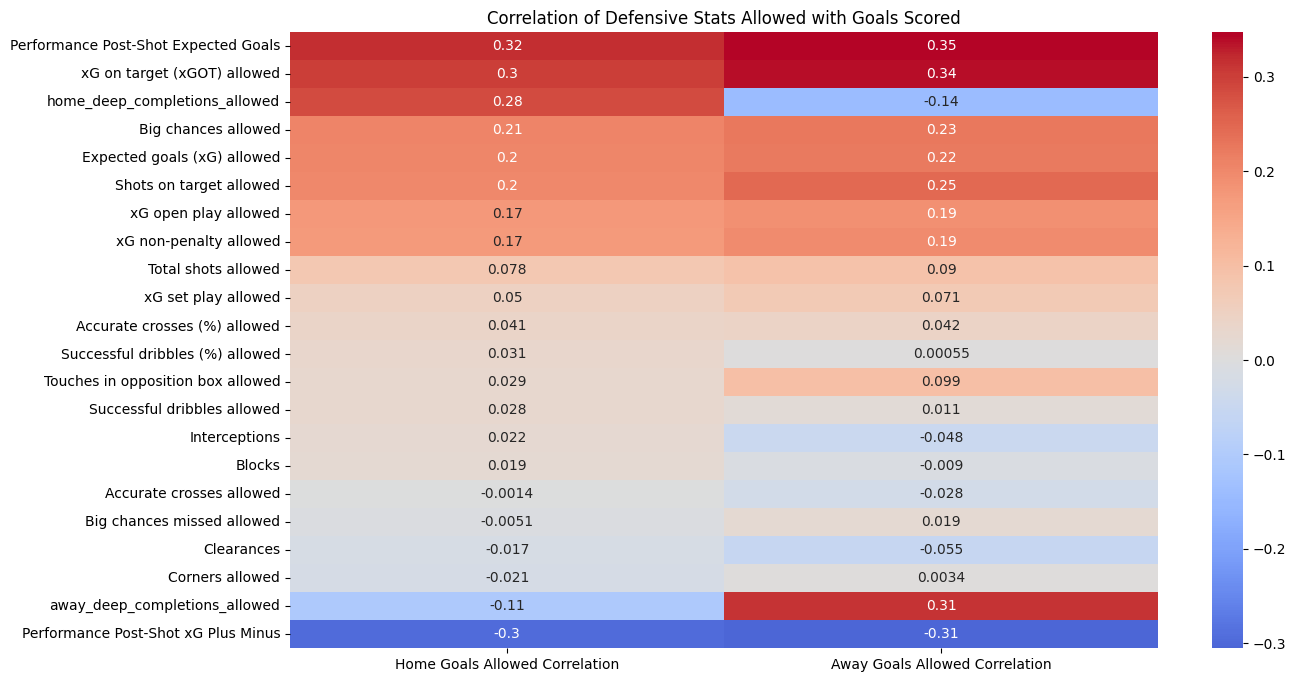

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with historical match data

# List of defensive-related stats modified to use the "Allowed" versions
defensive_stats_allowed = [
    'xG open play allowed', 'xG set play allowed', 'xG on target (xGOT) allowed', 'xG non-penalty allowed', 'Expected goals (xG) allowed',
    'Successful dribbles allowed', 'Successful dribbles (%) allowed', 'Clearances', 'Interceptions', 'Blocks',
    'Accurate crosses allowed', 'Accurate crosses (%) allowed', 'Touches in opposition box allowed', 'Total shots allowed', 'Shots on target allowed',
    'Big chances allowed', 'Corners allowed', 'Big chances missed allowed',
    'home_deep_completions_allowed', 'away_deep_completions_allowed', 'Performance Post-Shot Expected Goals', 'Performance Post-Shot xG Plus Minus'
]

# Calculate the correlation of each defensive stat allowed with 'home_goals' and 'away_goals'
correlations_defensive = {}
for stat in defensive_stats_allowed:
    correlation_with_home_goals = merged_df[stat].corr(merged_df['home_goals_allowed'])  # Correlate with goals scored by the home team
    correlation_with_away_goals = merged_df[stat].corr(merged_df['away_goals_allowed'])  # Correlate with goals scored by the away team
    correlations_defensive[stat] = {
        'Home Goals Allowed Correlation': correlation_with_home_goals,
        'Away Goals Allowed Correlation': correlation_with_away_goals
    }

# Convert the correlations dictionary to a DataFrame for easier analysis
correlation_df_defensive = pd.DataFrame(correlations_defensive).T

# Sort the DataFrame based on 'Home Goals Correlation' in descending order
correlation_df_defensive = correlation_df_defensive.sort_values(by='Home Goals Allowed Correlation', ascending=False)

# Print the sorted correlation DataFrame
print(correlation_df_defensive)

# Plot the correlations
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_df_defensive, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Defensive Stats Allowed with Goals Scored')
plt.show()


In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame with historical match data

# List of defensive-related stats based on the correlations provided
defensive_stats = [
    'xG open play allowed', 'xG set play allowed', 'xG on target (xGOT) allowed', 'xG non-penalty allowed', 'Expected goals (xG) allowed',
    'Successful dribbles allowed', 'Successful dribbles (%) allowed', 'Clearances', 'Interceptions', 'Blocks',
    'Accurate crosses allowed', 'Accurate crosses (%) allowed', 'Touches in opposition box allowed', 'Total shots allowed', 'Shots on target allowed',
    'Big chances allowed', 'Corners allowed', 'Big chances missed allowed',
    'home_deep_completions_allowed', 'away_deep_completions_allowed', 'Performance Post-Shot Expected Goals', 'Performance Post-Shot xG Plus Minus'
]



# Calculate the weights, inverting the sign of the correlation to reward lower values
correlation_df_defensive['Home Weight'] = -correlation_df_defensive['Home Goals Allowed Correlation'] / correlation_df_defensive['Home Goals Allowed Correlation'].abs().sum()
correlation_df_defensive['Away Weight'] = -correlation_df_defensive['Away Goals Allowed Correlation'] / correlation_df_defensive['Away Goals Allowed Correlation'].abs().sum()

# Exclude 'home_deep_completions allowed' for away metric calculation
away_weights_defensive = correlation_df_defensive.drop('home_deep_completions_allowed', axis=0)['Away Weight']

# Exclude 'away_deep_completions_allowed' for home metric calculation
home_weights_defensive = correlation_df_defensive.drop('away_deep_completions_allowed', axis=0)['Home Weight']

# Display the weights
print("Home Defensive Weights (rewarding lower values):\n", home_weights_defensive)
print("\nAway Defensive Weights (rewarding lower values):\n", away_weights_defensive)

Home Defensive Weights (rewarding lower values):
 Performance Post-Shot Expected Goals   -0.121773
xG on target (xGOT) allowed            -0.116158
home_deep_completions_allowed          -0.109193
Big chances allowed                    -0.079036
Expected goals (xG) allowed            -0.077913
Shots on target allowed                -0.077274
xG open play allowed                   -0.066603
xG non-penalty allowed                 -0.066346
Total shots allowed                    -0.029977
xG set play allowed                    -0.018975
Accurate crosses (%) allowed           -0.015583
Successful dribbles (%) allowed        -0.012039
Touches in opposition box allowed      -0.010974
Successful dribbles allowed            -0.010730
Interceptions                          -0.008437
Blocks                                 -0.007314
Accurate crosses allowed                0.000522
Big chances missed allowed              0.001970
Clearances                              0.006355
Corners allowed    

In [ ]:
import pandas as pd
from scipy.stats import zscore

# Assuming merged_df is your DataFrame with historical match data


# Standardize the stats that contain "allowed" across the dataset
import pandas as pd
from scipy.stats import zscore

# Assuming merged_df is your DataFrame with historical match data

# Standardize the stats specified in the defensive_stats list
for stat in defensive_stats:
    if stat in merged_df.columns:  # Check if the stat is a column in the DataFrame
        # Compute the Z-score for each specified stat
        merged_df[f'{stat}_z'] = zscore(merged_df[stat].fillna(0))

# Define a function to calculate the defensive metric using Z-scores and weights
def calculate_defensive_metric_z(row, home_weights, away_weights):
    metric = 0
    weights = home_weights if row['team'] == row['home_team'] else away_weights

    for stat, weight in weights.items():
        z_stat = f'{stat}_z'  # Make


# Define a function to calculate the defensive metric using Z-scores and weights
def calculate_defensive_metric_z(row, home_weights, away_weights):
    metric = 0
    weights = home_weights if row['team'] == row['home_team'] else away_weights

    for stat, weight in weights.items():
        z_stat = f'{stat}_z'  # Make sure this is the correct column name
        if z_stat in row.index:
            metric += row[z_stat] * weight

    return metric

# Calculate the defensive metric for each game using Z-scores
merged_df['defensive_metric_z'] = merged_df.apply(
    calculate_defensive_metric_z, axis=1, args=(home_weights_defensive, away_weights_defensive)
)

# Identify the specific Arsenal game against West Ham United in the '2324' season
arsenal_game_z = merged_df[(merged_df['away_team'] == 'Arsenal') &
                           (merged_df['home_team'] == 'West Ham United') &
                           (merged_df['season'] == 2324)]

# Calculate contributions of each stat to the defensive metric for the specific game
if not arsenal_game_z.empty:
    game_row = arsenal_game_z.iloc[0]
    contributions = {}
    weights = away_weights_defensive  # Use away weights since Arsenal is the away team

    print(f"Defensive performance details for Arsenal against West Ham United:\n")
    for stat, weight in weights.items():
        z_stat = f'{stat}_z'
        if z_stat in game_row:
            value = game_row[stat] if pd.notnull(game_row[stat]) else 0
            z_score = game_row[z_stat] if pd.notnull(game_row[z_stat]) else 0
            contribution = z_score * weight
            contributions[stat] = contribution
            print(f"{stat}: Value = {value}, Z-score = {z_score:.4f}, Weight = {weight}, Contribution = {contribution:.4f}")

    total_defensive_metric = sum(contributions.values())
    print(f"\nTotal Defensive Metric for Arsenal: {total_defensive_metric:.4f}")
else:
    print("Specific game not found.")


Defensive performance details for Arsenal against West Ham United:

Performance Post-Shot Expected Goals: Value = 0.2, Z-score = -1.0688, Weight = -0.11562027805529883, Contribution = 0.1236
xG on target (xGOT) allowed: Value = 0.2, Z-score = -1.0884, Weight = -0.11232289046619878, Contribution = 0.1223
Big chances allowed: Value = 0.0, Z-score = -1.1790, Weight = -0.07545828215691566, Contribution = 0.0890
Expected goals (xG) allowed: Value = 0.22, Z-score = -1.3517, Weight = -0.07443780234993347, Contribution = 0.1006
Shots on target allowed: Value = 1.0, Z-score = -1.3043, Weight = -0.0820721235232745, Contribution = 0.1070
xG open play allowed: Value = 0.22, Z-score = -1.0694, Weight = -0.0627550110222867, Contribution = 0.0671
xG non-penalty allowed: Value = 0.22, Z-score = -1.3092, Weight = -0.06469853850753422, Contribution = 0.0847
Total shots allowed: Value = 5.0, Z-score = -1.2818, Weight = -0.029896892935536438, Contribution = 0.0383
xG set play allowed: Value = 0.0, Z-score

In [ ]:
import pandas as pd
from scipy.stats import zscore

# Assuming merged_df is your DataFrame with historical match data
merged_df.sort_values(by='date', ascending=True, inplace=True)



# Define a function to calculate the defensive metric using Z-scores
def calculate_defensive_metric(row, home_weights, away_weights):
    metric = 0
    weights = home_weights if row['team'] == row['home_team'] else away_weights

    for stat, weight in weights.items():
        z_stat = f'{stat}_z'
        if z_stat in row:
            metric += row[z_stat] * weight
    return metric

# Calculate the defensive metric for each game
merged_df['defensive_metric_z'] = merged_df.apply(
    calculate_defensive_metric, axis=1, args=(home_weights_defensive, away_weights_defensive)
)

# Calculate the rolling average of the last 5 defensive metrics for each team and season
merged_df['avg_last_5_defensive_metric_z'] = merged_df.groupby(['season', 'team'])['defensive_metric_z'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean().shift()
)

# Calculate the season average defensive metric up to the current game for each team and season
merged_df['season_avg_defensive_metric_z'] = merged_df.groupby(['season', 'team'])['defensive_metric_z'].transform(
    lambda x: x.expanding().mean().shift()
)

# Filter the DataFrame for a specific game to check the results
specific_game = merged_df[
    (merged_df['date'] == '2024-02-11') &
    ((merged_df['home_team'] == 'West Ham United') | (merged_df['away_team'] == 'Arsenal'))
]
print(specific_game[['game_id_team', 'team', 'home_team', 'away_team', 'date', 'season', 'defensive_metric_z', 'avg_last_5_defensive_metric_z', 'season_avg_defensive_metric_z']])


      game_id_team             team        home_team away_team        date  \
5030       4193769          Arsenal  West Ham United   Arsenal  2024-02-11   
5031       4193769  West Ham United  West Ham United   Arsenal  2024-02-11   

      season  defensive_metric_z  avg_last_5_defensive_metric_z  \
5030    2324            0.917638                       0.434285   
5031    2324           -2.353896                      -0.455042   

      season_avg_defensive_metric_z  
5030                       0.416457  
5031                      -0.339386  
